In [1]:
import pandas as pd
import numpy as np
import transformers
from sklearn.preprocessing import MinMaxScaler, StandardScaler

train_data = pd.read_csv('stockprice_master_NSE-TATAGLOBAL.csv')

In [2]:
steps = 60

In [3]:
transformer, train_data = transformers.format_data(train_data)

In [4]:
X_train, y_train = transformers.create_sequences(train_data, steps)

In [5]:
# from keras_tuner import HyperParameters, GridSearch
# from keras.models import Model, load_model
# from keras.layers import Input,Dense, LSTM, Dropout
# from keras.callbacks import EarlyStopping
# from keras.losses import CategoricalCrossentropy
# from keras.metrics import CategoricalAccuracy
# from keras.optimizers import Adam

In [6]:
# inputs = Input(shape=(X_train[1].shape))
# lstm1 = LSTM(units=50,return_sequences=True)(inputs)
# dropout = Dropout(0.2)(lstm1)
# lstm2 = LSTM(units=50, return_sequences=True)(dropout)
# dropout = Dropout(0.2)(lstm2)
# lstm3 = LSTM(units=50)(dropout)
# dropout = Dropout(0.2)(lstm3)
# output = Dense(units=1)(dropout)
# model = Model(inputs,output,name='stock-price-prediction')
# model.compile(optimizer='adam',loss='mean_squared_error')
# model.fit(X_train,y_train,epochs=8)

In [7]:
# model.save('results/model.keras')

In [8]:
from keras.models import Model, load_model
model: Model = load_model('results/model.keras')

In [9]:
test_data = pd.read_csv('mwitiderrick_stockprice_master_tatatest.csv')

In [10]:
real_values = test_data['Open'].values.reshape(-1,1)

In [11]:
test_data= transformer.transform(test_data.iloc[::-1])

In [12]:
newdata = np.append(train_data[-steps:,:],test_data,axis=0)

In [13]:
X_test = []
for i in range(60, 76):
    X_test.append(newdata[i-60:i, :])
X_test = np.array(X_test)

In [14]:
predictions = model.predict(X_test)

1/1 [==============================] - 1s 948ms/step


In [15]:
open_scaler = transformer.transformers_[1][1]

In [16]:
predictions = open_scaler.inverse_transform(predictions)

In [18]:
import matplotlib.pyplot as plt

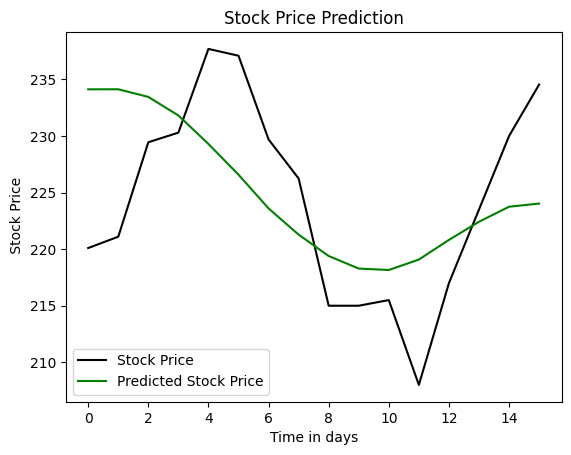

In [28]:
plt.plot(real_values, color = 'black', label = 'Stock Price')
plt.plot(predictions, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time in days')
plt.ylabel(' Stock Price')
plt.legend()
plt.savefig('results/Stock-price-fig')


In [33]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

results = {'Mean Abs % Err': (mean_absolute_percentage_error(real_values,predictions)*100).round(3),'Root Mean Sq. Err': np.sqrt(mean_squared_error(real_values,predictions)).round(3)}
results

{'Mean Abs % Err': 2.942, 'Root Mean Sq. Err': 7.72}